# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimisation

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2020-08-25,3346.489990,26.000000,344.709991,129.789993,419.359985,47.910000,211.413132,216.470001,4.301204,82.720001
2020-08-26,3441.850098,25.559999,344.269989,132.179993,418.089996,48.160000,212.516678,221.149994,4.120000,82.410004
2020-08-27,3400.000000,26.049999,346.359985,133.729996,416.320007,48.230000,210.955826,226.580002,4.130000,83.410004
2020-08-28,3401.800049,26.299999,348.369995,135.539993,415.980011,49.830002,213.660004,228.910004,4.330000,85.000000
2020-08-31,3458.793945,25.895000,346.220001,133.895004,409.491699,49.980000,214.589996,226.830002,4.260000,84.699997


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    26.184059
1993-02-01    26.370279
1993-02-02    26.426161
1993-02-03    26.705482
1993-02-04    26.817228
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 1717553856512,
 'AMZN': 1733309759488,
 'NAT': 629412544,
 'BAC': 224443514880,
 'DPZ': 16112352256,
 'DIS': 241983406080,
 'KO': 214707568640,
 'MCD': 159736578048,
 'COST': 152822497280,
 'SBUX': 99002605568}

## Constructing the prior

In [6]:
import pypfopt
pypfopt.__version__

'1.2.5'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.575558029629306

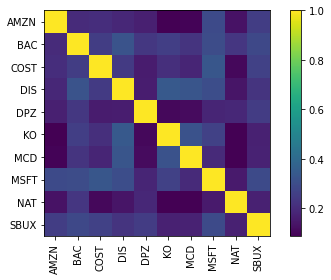

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.193986
BAC     0.100004
COST    0.073835
DIS     0.092934
DPZ     0.047207
KO      0.061453
MCD     0.066358
MSFT    0.128099
NAT     0.051273
SBUX    0.078730
dtype: float64

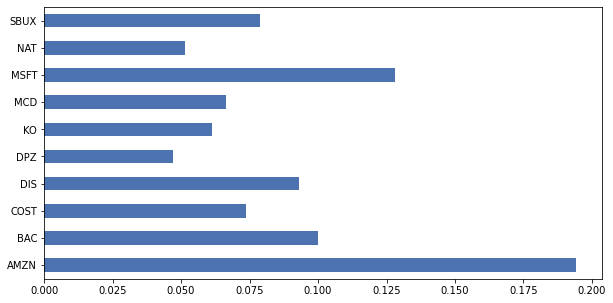

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

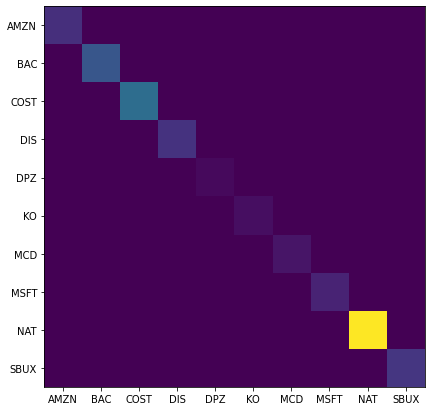

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.00459462, 0.00905481, 0.01215202, 0.0049799 , 0.00080269,
       0.00125624, 0.00197144, 0.00344094, 0.03400285, 0.0053881 ])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estiamte of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_averison="delta",
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.113118
BAC     0.148670
COST    0.052314
DIS     0.066618
DPZ     0.099989
KO      0.002436
MCD     0.106107
MSFT    0.094645
NAT     0.061771
SBUX    0.075484
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.193986,0.113118,0.10
BAC,0.100004,0.148670,0.30
COST,0.073835,0.052314,0.05
DIS,0.092934,0.066618,0.05
DPZ,0.047207,0.099989,0.20
KO,0.061453,0.002436,-0.05
MCD,0.066358,0.106107,0.15
MSFT,0.128099,0.094645,0.10
NAT,0.051273,0.061771,0.50
SBUX,0.078730,0.075484,0.10


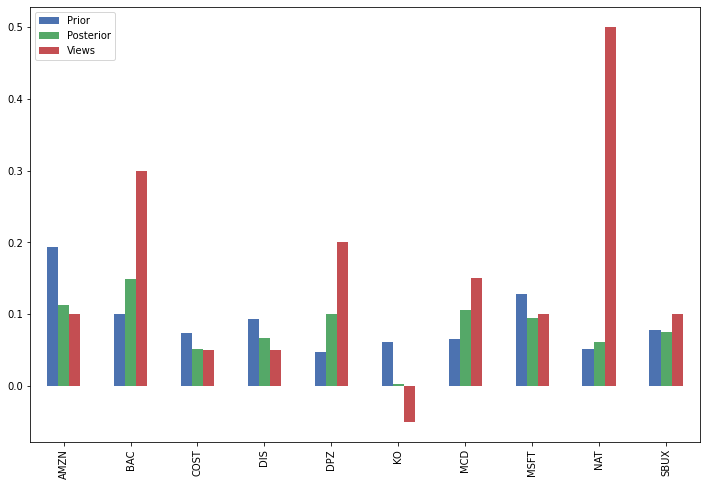

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is always between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

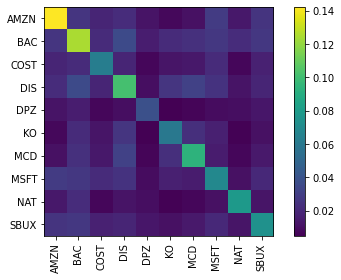

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/Robert/github/PyPortfolioOpt/pypfopt/efficient_frontier.py:195: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.14323),
             ('BAC', 0.20486),
             ('COST', 0.04403),
             ('DIS', 0.06171),
             ('DPZ', 0.14015),
             ('KO', 0.0),
             ('MCD', 0.14057),
             ('MSFT', 0.11864),
             ('NAT', 0.06354),
             ('SBUX', 0.08326)])

/Users/Robert/Library/Caches/pypoetry/virtualenvs/pyportfolioopt-0mcST3QB-py3.8/lib/python3.8/site-packages/pandas/plotting/_core.py:1539: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


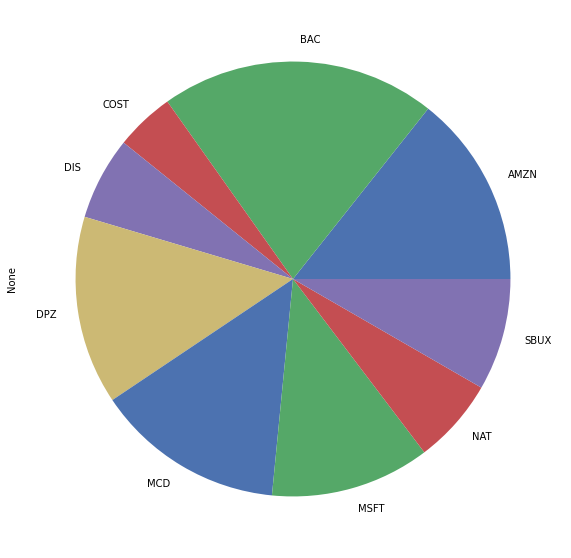

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.12


{'AMZN': 1,
 'BAC': 156,
 'COST': 2,
 'DIS': 9,
 'DPZ': 7,
 'MCD': 13,
 'MSFT': 10,
 'NAT': 291,
 'SBUX': 17}